# Brain Games PCA based on STFT

In [37]:
%matplotlib inline
import numpy as np
import scipy.io
import sklearn
from sklearn.decomposition import PCA
import scipy.cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
import time
from mpl_toolkits.mplot3d import Axes3D


from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

In [38]:
csvData = []
csvData.append(np.genfromtxt('DoingnothingbutnotblankingoutJustthinkspontaneouslyNoparticularTriggerEvent.csv', delimiter=','))
csvData.append(np.genfromtxt('2min1-100additionsubtraction.csv', delimiter=','))
csvData.append(np.genfromtxt('2min1-50multiplication.csv', delimiter=','))
print(csvData[0].shape)

sample_time = 120
sample_len = csvData[0].shape[0]
window_len = 0.5 #how long is each window in terms of seconds
window_num = (int)(sample_time//window_len) 
data_per_window = (int)(sample_len//(window_num)) #data_per_window = datapoints per window = sample_len // (window_num)

#assert(data_per_window % 2 == 0)

print("There are",data_per_window, "datapoints per window, and there are", window_num, "windows.")

(30577, 6)
There are 127 datapoints per window, and there are 240 windows.


In [39]:
channel = []
for d in csvData:
    channel.append(d[1:,4:5])
    print(d.shape)
    #plt.plot(rawData[:,:])
    #plt.xlim((0,rawData.shape[0]))
    #plt.title('A Very Representative Feature VS Full Time')
    #plt.figure(figsize = (16,9))
print(np.asarray(channel).shape)

(30577, 6)
(30577, 6)
(30577, 6)
(3, 30576, 1)


In [40]:
residual = sample_len % data_per_window
print("There are", residual, "points left out by segmentation, now cutting them from both ends...")
residualStart = residual // 2
residualEnd = residual - residualStart

pruned = []
for c in channel:
    pruned.append(c[residualStart : -residualEnd+1,:])
pruned = np.asarray(pruned)
print(pruned.shape)
for p in pruned:
    assert np.asarray(p).shape[0] % data_per_window == 0

There are 97 points left out by segmentation, now cutting them from both ends...
(3, 30480, 1)


Conglomerating the data from the pruned data...Easy to Hard...
(3, 30480)
(91440, 1)


<Figure size 1152x648 with 0 Axes>

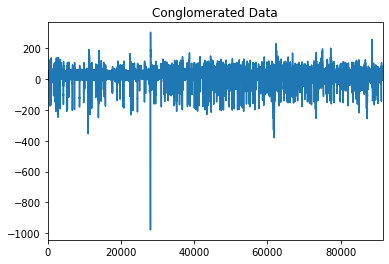

<Figure size 1152x648 with 0 Axes>

In [41]:
print("Conglomerating the data from the pruned data...Easy to Hard...")
pruned = np.reshape(pruned, newshape=(3,pruned[0].shape[0]))
print(pruned.shape)
conglomerated = pruned.flatten()
conglomerated = np.reshape(conglomerated,newshape=(conglomerated.shape[0],1))
print(conglomerated.shape)

plt.plot(conglomerated[:,:])
plt.xlim((0,conglomerated.shape[0]))
plt.title('Conglomerated Data')
plt.figure(figsize = (16,9))

In [45]:
nfft = 256 #should be the closest power of 2 to data_per_window

f,t,Zxx = scipy.signal.stft(conglomerated[:,0], nperseg=data_per_window, return_onesided=False, padded=True, nfft=nfft)
#assert (Zxx.shape[1] == 2*window_num*len(csvData) + 1)
print("There are", Zxx.shape[1],"time window captured by STFT...")
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


Zxx = Zxx.T #Zxx = new data matrix --> time windows are our new data points and frequency are the features
#We sacrificed segements of data to expand feature size from 1 to 256
#print(Zxx.shape)


print("Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...")
for i in range(0,Zxx.shape[0]):
    chnl = Zxx[i]
    chnl[0] = chnl[0].real
    chnl[1:nfft//2] = 1*chnl[1:nfft//2].real
    chnl[nfft//2] = chnl[nfft//2]
    chnl[nfft//2 + 1:] = (1)*chnl[nfft//2 + 1:].imag
assert ((Zxx.real == Zxx).all())
print("Coefficient extracted!")
Zxx = Zxx.real #The imaginary compoenent is 0 by now, we are just getting rid of the j for PCA
#Since PCA from sklearn doesn't handle complex data, let us simply use the weight of thecosine part of the frequency space


There are 1430 time window captured by STFT...
Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...
Coefficient extracted!
(1430, 256)


In [43]:
pc_num = 3

print("Doing PCA analysis ...")
start_time = time.time()
pca = PCA(n_components = pc_num)
pca.fit(Zxx)
mean = pca.mean_
pc = pca.components_[:pc_num]
end_time = time.time()
print("Done!")
print("Duration: ", end_time - start_time)


Doing PCA analysis ...
Done!
Duration:  0.009467840194702148


<IPython.core.display.Javascript object>


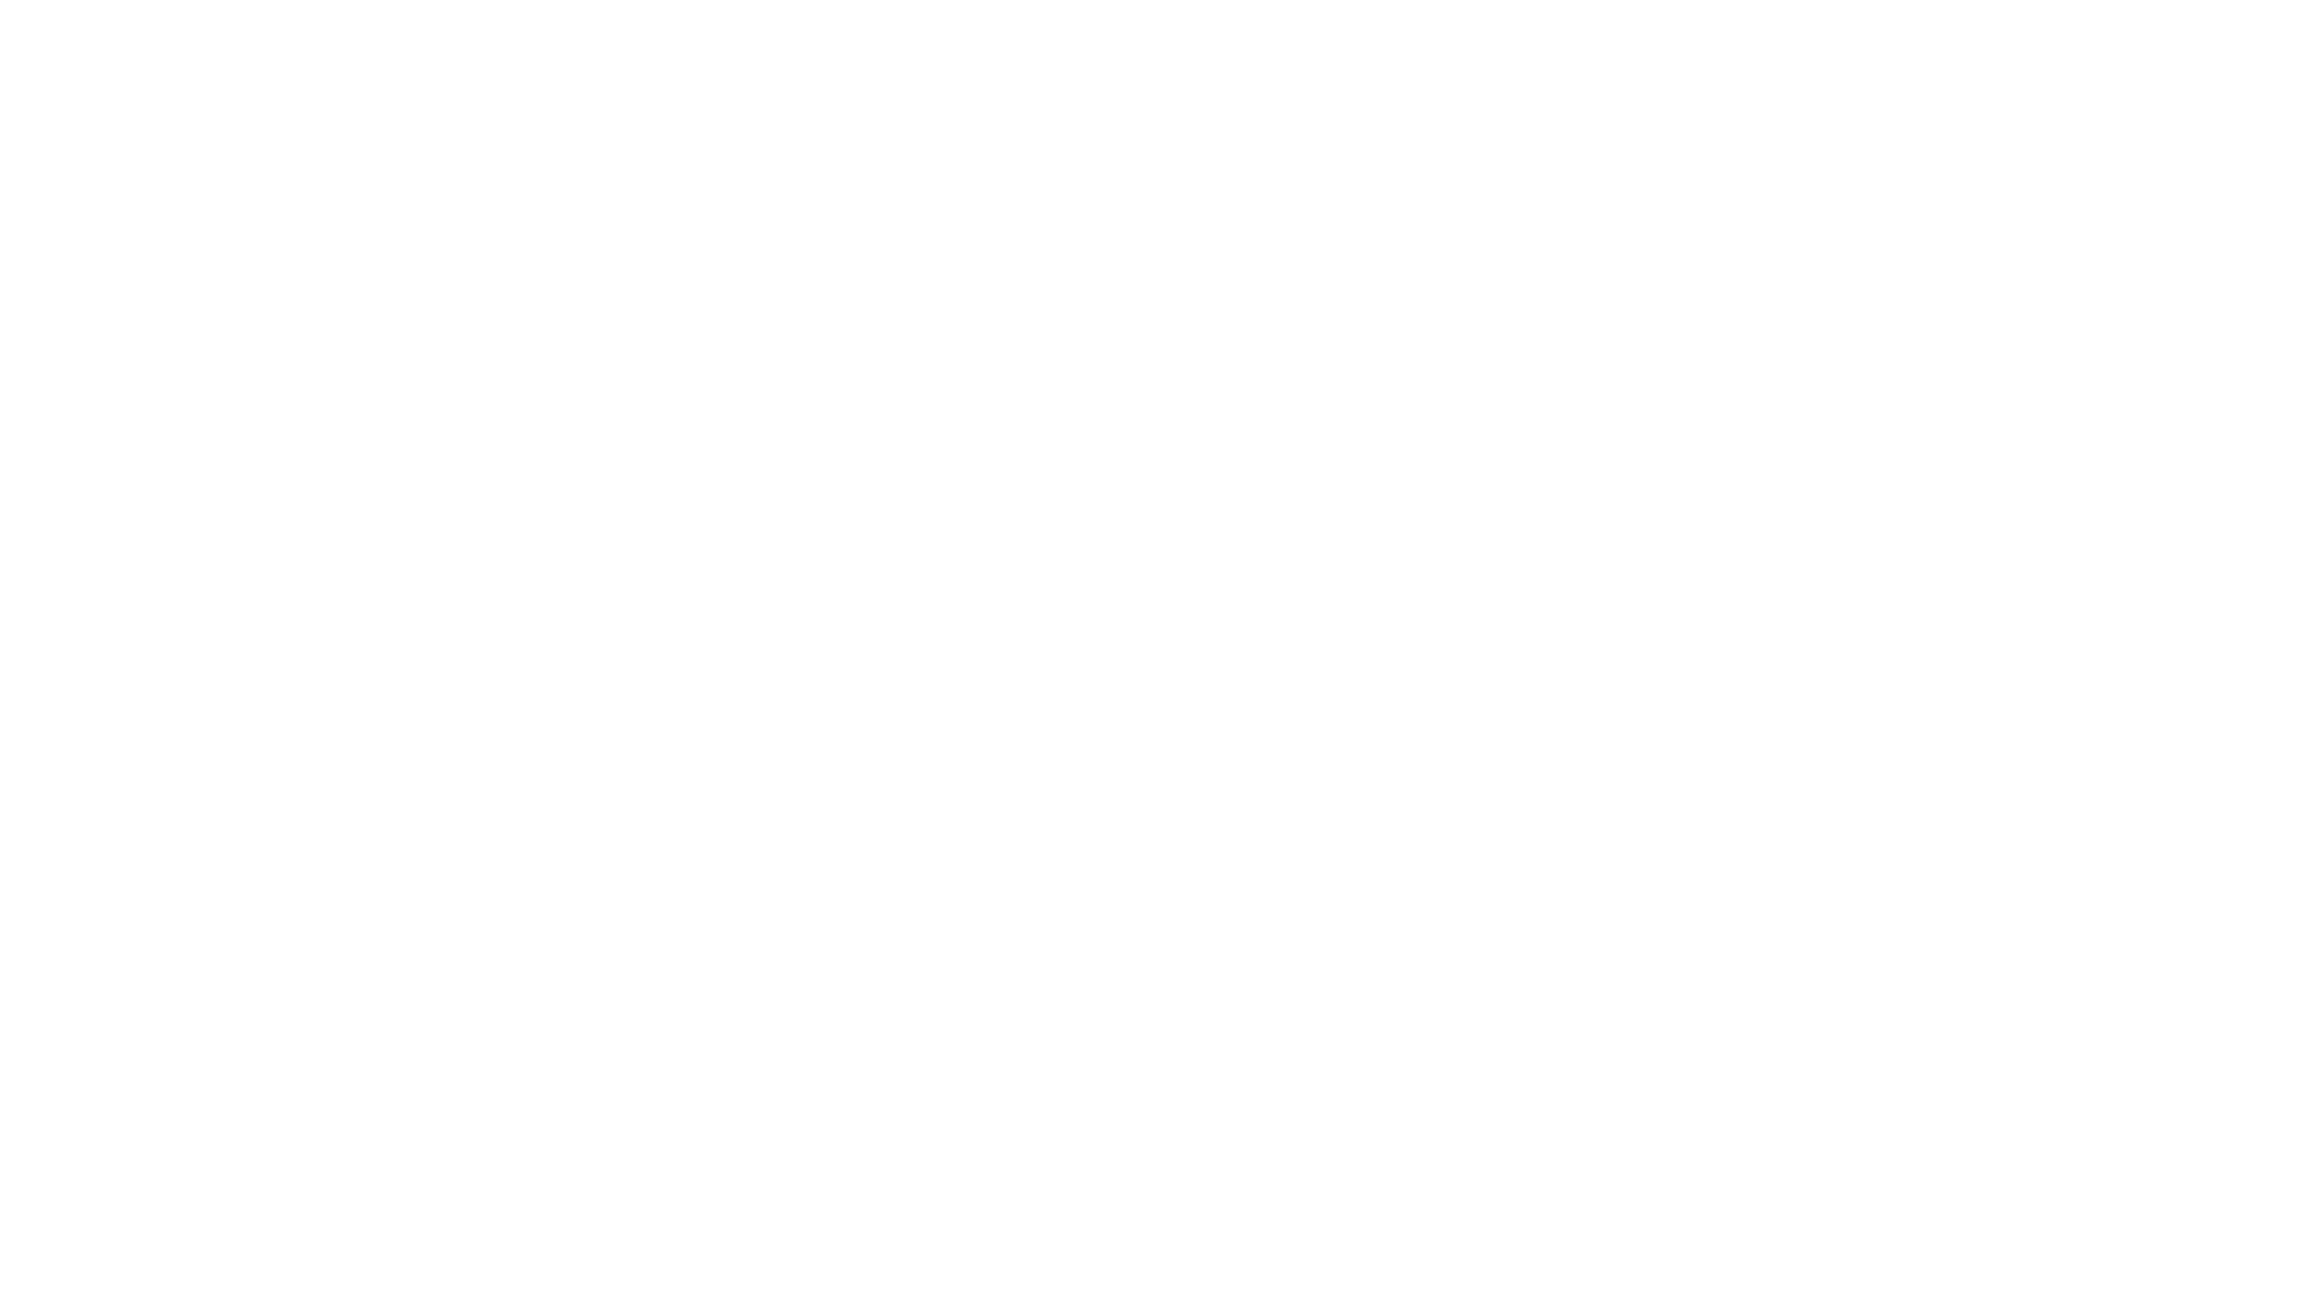

<IPython.core.display.Javascript object>


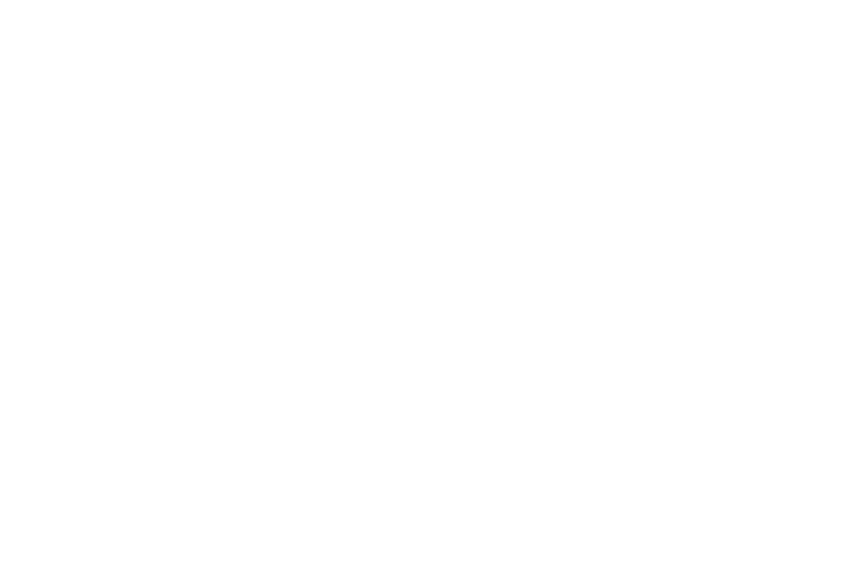

<IPython.core.display.Javascript object>


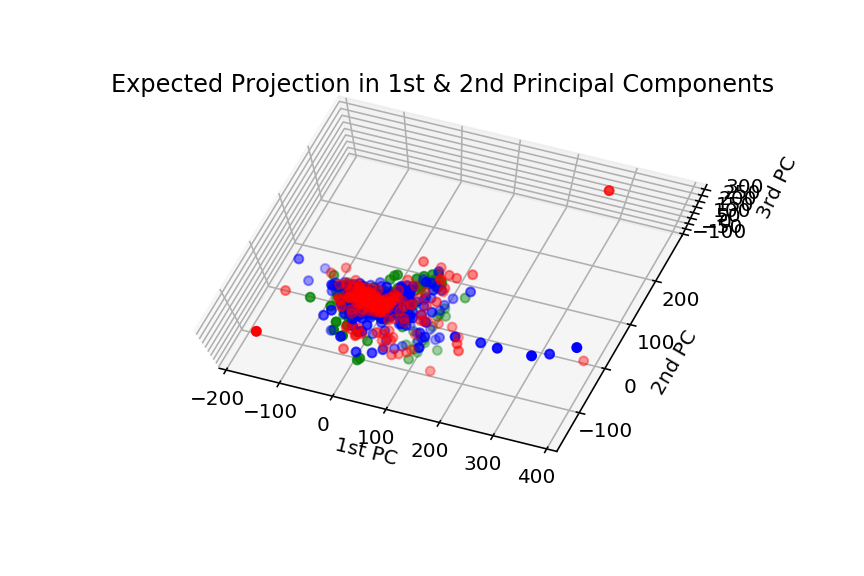

In [46]:
def PCA_project(data, new_basis, mean):
    #To see the data's repr in the basis of principal components
    return np.dot((data-mean), new_basis.T)
plt.figure(figsize = (16,9))
proj = PCA_project(Zxx, pc, mean)
fig = plt.figure()
#plt.figure(figsize = (16,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[:,0], proj[:,1], proj[:,2,], c='r', marker='o')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
#plt.scatter(*proj.T,s=50,c="r")
plt.title('Test Set Projection in 1st & 2nd & 3rd Principal Components')
plt.show()
%matplotlib notebook


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
projEasy = PCA_project(Zxx[0:Zxx.shape[0]//3,:], pc, mean)
ax.scatter(projEasy[:,0], projEasy[:,1], projEasy[:,2,], c='r', marker='o')
#plt.scatter(*projEasy.T,s=50,c="#87ceeb")
projMedium = PCA_project(Zxx[Zxx.shape[0]//3:2*Zxx.shape[0]//3,:], pc, mean)
ax.scatter(projMedium[:,0], projMedium[:,1], projMedium[:,2,], c='g', marker='o')
#plt.scatter(*projMedium.T,s=50,c="#ffa500")
projHard = PCA_project(Zxx[2*Zxx.shape[0]//3:,:], pc, mean)
ax.scatter(projHard[:,0], projHard[:,1], projHard[:,2,], c='b', marker='o')
#plt.scatter(*projHard.T,s=50,c="#F9C4F1")
plt.title('Expected Projection in 1st & 2nd Principal Components')
plt.show()